<h3>Imports and setup</h3>

In [24]:
from pathlib import Path
import os
import tifffile
import czifile
from tqdm import tqdm
import napari
from napari.utils import nbscreenshot
import pandas as pd
import numpy as np


<h3>Image data scraping</h3>

In [37]:
# Define the directory containing the raw .czi files and annotations
directory_path = Path("./apeer_annotations/")

# Initialize an empty list to store the .czi and ome.tiff annotation filepaths
czi_images = []
annotations = []

# Iterate through the files in the directory
for file_path in directory_path.glob('*.czi'):
    # Append the file to the corresponding group
    czi_images.append(str(file_path))

# Iterate through the files in the directory
for file_path in directory_path.glob('*.tiff'):
    # Append the file to the corresponding group
    annotations.append(str(file_path))


<h3>Transforming .czi files into .tiff</h3>

In [57]:
# Define output directory for .tiff converted .czi files  
processed_czi_dir = "./processed_bf_organoids/train_images"

# Check if the output folder exists, create it if not
try:
    os.makedirs(processed_czi_dir)
    print(f"Output folder created: {processed_czi_dir}")
except FileExistsError:
    print(f"Output folder already exists: {processed_czi_dir}")
    
for filepath in tqdm(czi_images):
    # Get the filename without the extension
    filename = Path(filepath).stem

    # Read the .czi file and remove singleton dimensions
    img = czifile.imread(filepath)
    img = img.squeeze()

    # Save the image as a regular .tiff file under processed_bf_organoids/train_images
    tifffile.imwrite(os.path.join(processed_czi_dir, f"{filename}.tiff"), img)


Output folder created: ./processed_bf_organoids/train_images


100%|██████████| 119/119 [00:01<00:00, 80.41it/s]


<h3>Rename annotations and create a copy under preprocessed_annotations</h3>

In [58]:
# Define output directory for renamed annotations
processed_annotations = "./preprocessed_annotations"

# Check if the output folder exists, create it if not
try:
    os.makedirs(processed_annotations)
    print(f"Output folder created: {processed_annotations}")
except FileExistsError:
    print(f"Output folder already exists: {processed_annotations}")
    
for filepath in tqdm(annotations):
    # Get the filename without the extension
    filename = Path(filepath).stem
    # Remove _finalprediction.ome so it matches the original image names
    filename = filename.replace("_finalprediction.ome", "")
    
    # Read the ome.tiff file, ignore ome
    img = tifffile.imread(filepath, is_ome=False)
    
    # Save the image as a regular .tiff file under preprocessed_annotations
    tifffile.imwrite(os.path.join(processed_annotations, f"{filename}.tiff"), img)

Output folder created: ./preprocessed_annotations


100%|██████████| 119/119 [00:01<00:00, 79.30it/s]


<h3>Process organoid annotations into organoid_train_masks</h3>

In [85]:
# Define the directory containing the renamed annotation files
prep_annotation_path = Path("./preprocessed_annotations/")

# Initialize an empty list to store the renamed annotation filepaths
preprocessed_annotations = []

# Iterate through the files in the directory
for file_path in prep_annotation_path.glob('*.tiff'):
    # Append the file to the corresponding group
    preprocessed_annotations.append(str(file_path))

# Define output directory for processsed dead_organoid annotations
processed_dead_annotations = "./processed_bf_organoids/train_masks/dead"
processed_diff_annotations = "./processed_bf_organoids/train_masks/differentiated"
processed_undiff_annotations = "./processed_bf_organoids/train_masks/undifferentiated"

# Store the directories in a list to loop through them
proc_ann_directories = [processed_dead_annotations, processed_diff_annotations, processed_undiff_annotations]

# Check if the output folders exists, create it if not
for directory in proc_ann_directories:
        
    try:
        os.makedirs(directory)
        print(f"Output folder created: {directory}")
    except FileExistsError:
        print(f"Output folder already exists: {directory}")
    
# Loop trough each .tiff containing the class annotations
for filepath in tqdm(preprocessed_annotations):
    
    # Get the filename without the extension
    filename = Path(filepath).stem
    
    # Read the .tiff containing all 3 class annotations
    img = tifffile.imread(filepath, is_ome=False)

    # Extract the channel dimension containing each class annotation
    dead_organoids = img[0,:,:]
    diff_organoids = img[1,:,:]
    undiff_organoids = img[2,:,:]

    # Binarize the arrays
    dead_organoids = np.where(dead_organoids !=0, 255, 0)
    diff_organoids = np.where(diff_organoids !=0, 255, 0)
    undiff_organoids = np.where(undiff_organoids !=0, 255, 0)

    # Convert the array to uint8
    dead_organoids = dead_organoids.astype(np.uint8)
    diff_organoids = diff_organoids.astype(np.uint8)
    undiff_organoids = undiff_organoids.astype(np.uint8)

    # Store the resulting array as a .tiff file under train masks
    tifffile.imwrite(os.path.join(processed_dead_annotations, f"{filename}.tiff"), dead_organoids)
    tifffile.imwrite(os.path.join(processed_diff_annotations, f"{filename}.tiff"), diff_organoids)
    tifffile.imwrite(os.path.join(processed_undiff_annotations, f"{filename}.tiff"), undiff_organoids)

Output folder already exists: ./processed_bf_organoids/train_masks/dead
Output folder created: ./processed_bf_organoids/train_masks/differentiated
Output folder created: ./processed_bf_organoids/train_masks/undifferentiated


100%|██████████| 119/119 [00:02<00:00, 44.71it/s]


<h3>Visualization</h3>

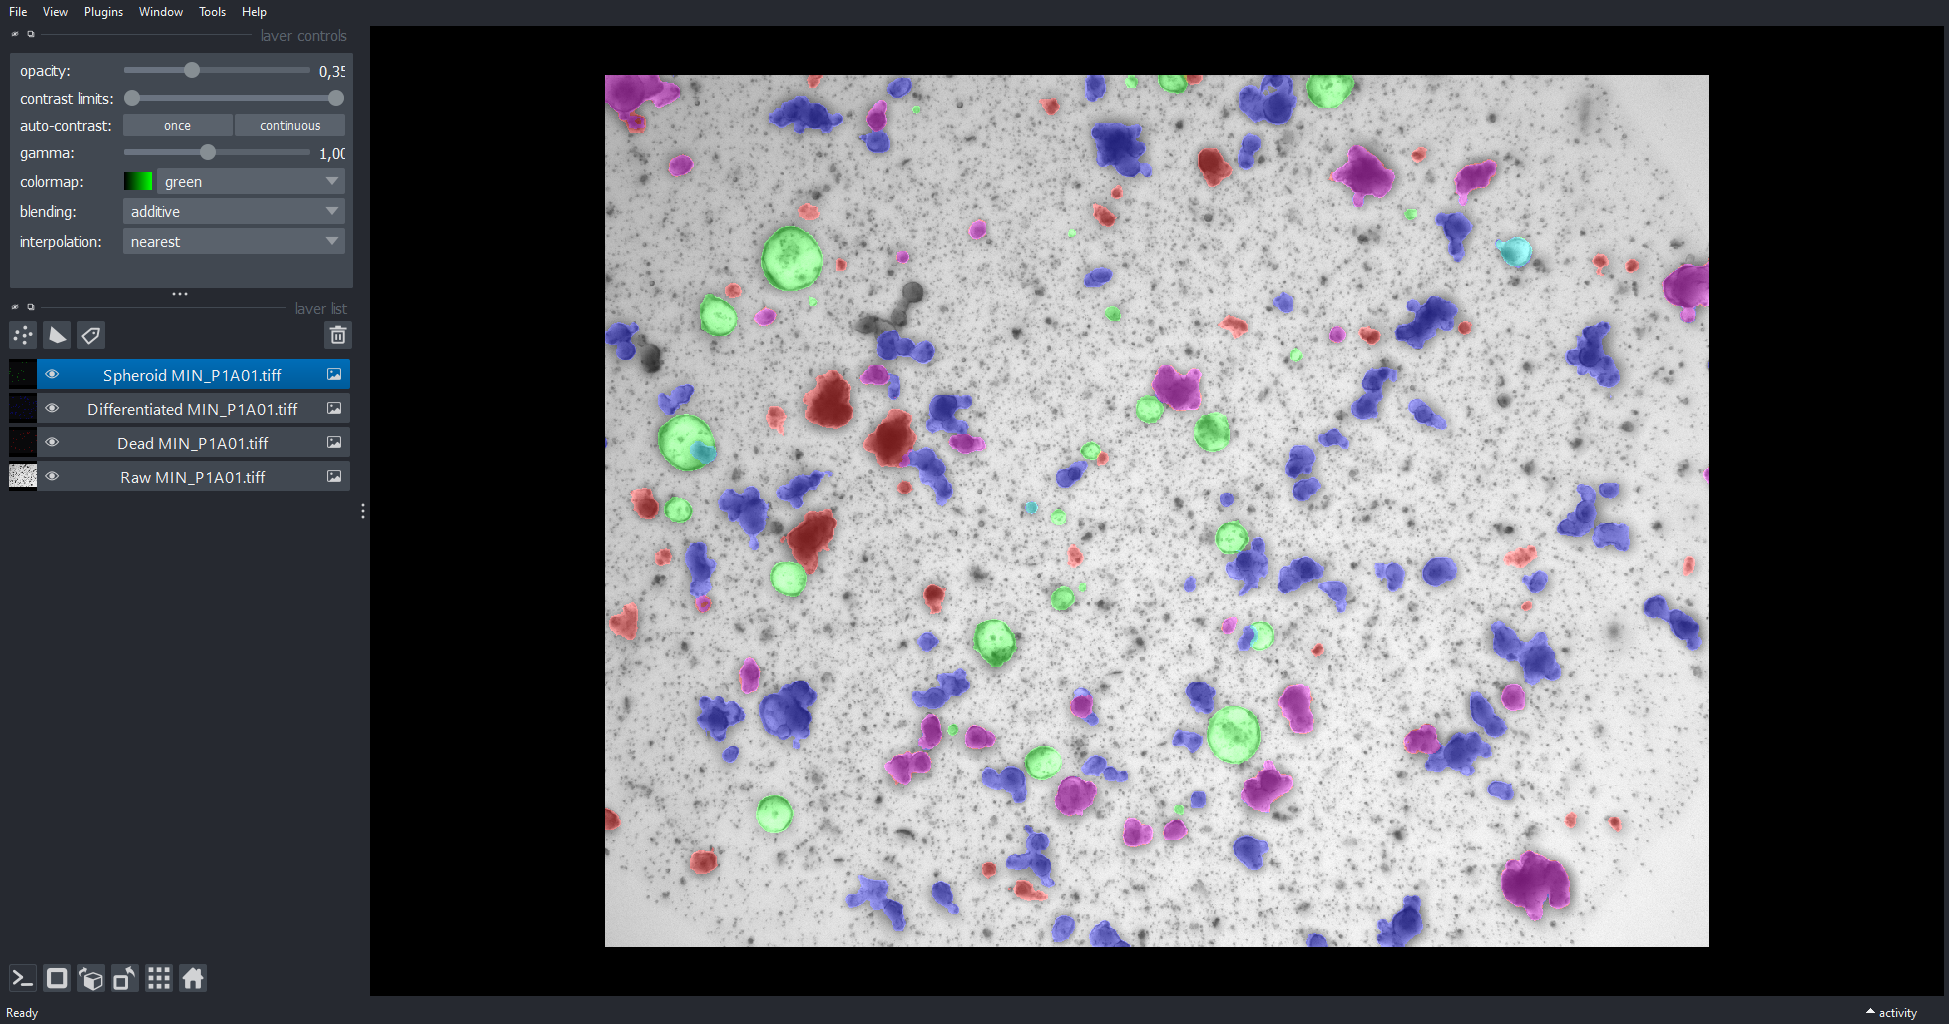

In [25]:
# Define below the filename you want to display together with the corresponding classes
file = "MIN_P1A01.tiff"

# Initialize Napari instance to display raw_images together with class masks
viewer = napari.Viewer(ndisplay=2)

# Read raw image and class labels to display
raw_img = tifffile.imread(f"./processed_bf_organoids/train_images/{file}", is_ome=False)
dead_mask = tifffile.imread(f"./processed_bf_organoids/train_masks/dead/{file}", is_ome=False)
diff_mask =  tifffile.imread(f"./processed_bf_organoids/train_masks/differentiated/{file}", is_ome=False)
undiff_mask = tifffile.imread(f"./processed_bf_organoids/train_masks/undifferentiated/{file}", is_ome=False)

#TODO: Change colors for each label.
# Display in Napari
viewer.add_image(raw_img, name=f"Raw {file}")
viewer.add_image(dead_mask, name=f"Dead {file}", colormap="red", opacity=0.35, blending="additive")
viewer.add_image(diff_mask, name=f"Differentiated {file}",colormap="blue", opacity=0.35, blending="additive")
viewer.add_image(undiff_mask, name=f"Spheroid {file}", colormap="green", opacity=0.35, blending="additive")

# Screenshot for documentation purposes
nbscreenshot(viewer)

<h3>Data quality checks</h3>

<p>Counting the number of objects per class in ./processed_bf_organoids/train_masks and checking against what's in Apeer's measurements_default.csv file </p>

In [21]:
# Read measurements_default.csv containing each object_id's class_name
df = pd.read_csv("./apeer_annotations/measurements_default.csv")

In [22]:
df

,file_name,class_name,time,z,well_id,object_id,area,area_um2,bbox_y_start,bbox_y_start_um,...,filled_area,filled_area_um2,major_axis_length,major_axis_length_um,minor_axis_length,minor_axis_length_um,orientation,perimeter,perimeter_um,solidity
0,MIN_StackC01,Dead,1,1,A1,1,428,7.998418e+15,13,5.619834e+07,...,428,7.998418e+15,24.715452,1.068437e+08,22.219819,9.605516e+07,-0.675140,76.183766,3.293386e+08,0.957494
1,MIN_StackC01,Dead,1,1,A1,2,529,9.885895e+15,133,5.749523e+08,...,529,9.885895e+15,26.578549,1.148977e+08,25.479090,1.101448e+08,-1.520972,85.012193,3.675034e+08,0.958333
2,MIN_StackC01,Dead,1,1,A1,3,783,1.463262e+16,274,1.184488e+09,...,783,1.463262e+16,36.811543,1.591344e+08,28.224519,1.220132e+08,0.191509,112.325902,4.855792e+08,0.932143
3,MIN_StackC01,Dead,1,1,A1,4,361,6.746329e+15,76,3.285442e+08,...,361,6.746329e+15,25.020680,1.081631e+08,18.514458,8.003707e+07,0.494603,70.526912,3.048843e+08,0.960106
4,MIN_StackC01,Dead,1,1,A1,5,5328,9.956909e+16,14,6.052129e+07,...,5328,9.956909e+16,97.666795,4.222086e+08,78.028768,3.373144e+08,-1.023491,374.333044,1.618223e+09,0.805564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29892,MIN_stack_C02,Undifferentiated,1,1,A1,382,150,2.803184e+15,934,4.037635e+09,...,150,2.803184e+15,14.631180,6.324985e+07,13.319835,5.758097e+07,-0.294475,44.485281,1.923076e+08,0.955414
29893,MIN_stack_C02,Undifferentiated,1,1,A1,383,82,1.532407e+15,1021,4.413731e+09,...,82,1.532407e+15,10.931129,4.725472e+07,9.567631,4.136039e+07,0.737436,31.313708,1.353676e+08,0.942529
29894,MIN_stack_C02,Undifferentiated,1,1,A1,384,28,5.232610e+14,941,4.067895e+09,...,28,5.232610e+14,7.864874,3.399945e+07,4.772463,2.063112e+07,-0.965517,18.485281,7.991094e+07,0.965517
29895,MIN_stack_C02,Undifferentiated,1,1,A1,385,107,1.999605e+15,997,4.309981e+09,...,107,1.999605e+15,12.773655,5.521987e+07,10.737002,4.641552e+07,0.855616,36.384776,1.572896e+08,0.963964
